Basic graphs. Let's look at a relatively short time period (1900-1910) and make a graph of authors.

Fish out keywords and authors from the json files for PR articles. In the future this should be replaced with a database.

Dependencies:

conda install graphviz

conda install --channel https://conda.anaconda.org/coursera pygraphviz

In [1]:
%matplotlib inline
import os
import sys
import json
from dateutil import parser
from datetime import date, timedelta
import re
from nltk.corpus import stopwords
s=stopwords.words('english') + ['', 'using']
import time
import itertools
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import pygraphviz as pgv
from sklearn.cluster import spectral_clustering
from sklearn.cluster import AgglomerativeClustering

Cases that are not handles well in the search:

*PhysRev.1.294: Authors are "R. W. and R. C. Duncan", which I assume means "R. W. Duncan and R. C. Duncan.

In [2]:
# Walk through directory
# baseDirectories = ['../aps-dataset-metadata-2013/PR/', '../aps-dataset-metadata-2013/PRL/']
# baseDirectories = ['../aps-dataset-metadata-2013/PR/1']
baseDirectories = ['../aps-dataset-metadata-2013/PR/']

startdate = date(1945,1,1)
finaldate = date(1960,1,1)
# There are no abstracts!
titles = []
authors = []
datestamp = []

start = time.time()

abort = False
for basedir in baseDirectories:
    for (dirpath, dirnames, filenames) in os.walk(basedir):
        for currentFile in filenames:
            if currentFile.endswith('.json'):
#                 print currentFile
                with open(os.path.join(dirpath, currentFile), 'r') as f:
                    data = json.load(f)
                    if ('authors' in data.keys()) and \
                        (parser.parse(data['date']).date() < finaldate)  and \
                        (parser.parse(data['date']).date() > startdate):
                        authors.append([x['name'].rstrip().title() for x in data['authors'] if 'authors' in data.keys()])
#                         if any(['Compton' in x['name'] for x in data['authors']]):
#                             print data['authors']
                    

final = time.time()
print "%0.1f articles/second (%i articles in %0.1f seconds)" % (len(titles)/(final-start), len(titles), final-start)

0.0 articles/second (0 articles in 18.9 seconds)


Assume authors names are unique. Fixing this assumption is probably hard.

In [3]:
graph = nx.Graph()

graph.add_nodes_from(set(itertools.chain(*authors)))

for item in authors:
    if len(item) > 1:
        graph.add_edges_from(itertools.combinations(item, 2))

How connected is the graph?

In [4]:
start = time.time()
print 'Number of connected components: %i' % len(list(nx.connected_components(graph)))
print '%0.1f seconds' % (time.time() - start,)

Number of connected components: 2808
0.0 seconds


What do the connected components look like? Nearly everyone is connected.

In [319]:
h = list(nx.connected_component_subgraphs(graph))
h_cluster = sorted(h, key=lambda x: -len(x))
h_main = h_cluster[0]
print [len(x) for x in h_cluster[0:5]]

[6695, 33, 30, 27, 18]


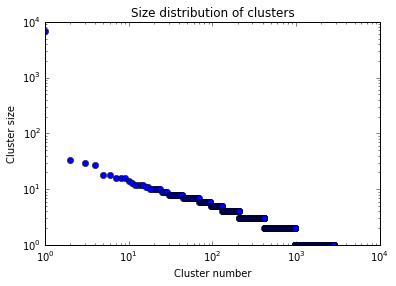

In [320]:
plt.loglog(range(1,1+len(h_cluster)), [len(x) for x in h_cluster],'o')
# plt.show()
plt.xlabel('Cluster number')
plt.ylabel('Cluster size')
plt.title('Size distribution of clusters')
# plt.xlim(0, len(h_cluster))

Use scikits magic to find clusters.

In [321]:
start = time.time()
sparsemat = nx.to_scipy_sparse_matrix(h_main)
labels = spectral_clustering(sparsemat, n_clusters=8, eigen_solver='arpack')
labels2 = AgglomerativeClustering(n_clusters=8, linkage='ward').fit(sparsemat.toarray()).labels_
print '%0.1f sec' % (time.time() - start)

260.7 sec


In [322]:
inital_pos = dict()
fixed_nodes = []
for val in range(0, np.max(labels)+1):
    print np.sum(labels==val)
    theta = 2*np.pi*val/(np.max(labels)+1)
    fixed_nodes.append(h_main.nodes()[np.where(labels==val)[0][0]])
    for ind in np.where(labels==val)[0]:
        inital_pos[h_main.nodes()[ind]] = (10*np.cos(theta), 10*np.sin(theta))
#     fixed_pos[h_main.nodes()[np.where(labels==val)[0]] = (10*np.cos(theta), 10*np.sin(theta))
# #     fixed_pos[val] = (2*np.cos(theta), 0*np.sin(theta))
#     fixed_nodes.append(h_main.nodes()[np.where(labels==val)[0][0]])

17
5907
1
9
15
610
32
104


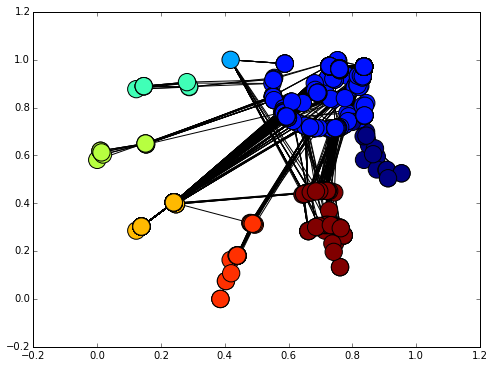

In [323]:
pos = nx.spring_layout(h_main, fixed=fixed_nodes, pos=inital_pos, iterations=4)
# nx.draw_networkx(h_main, pos=pos, node_color=labels)
nx.draw_networkx(h_main, pos=pos, node_color=labels, with_labels=False)
# f = plt.gcf()
plt.gcf().set_size_inches(8,6)
# ?plt.gcf() figure(figsize=(8,6))
# plt.show()

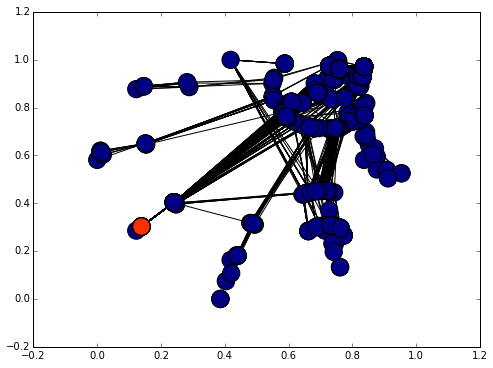

In [324]:
# pos = nx.spring_layout(h_main, fixed=fixed_nodes, pos=inital_pos, iterations=4)
# nx.draw_networkx(h_main, pos=pos, node_color=labels)
nx.draw_networkx(h_main, pos=pos, node_color=labels2, with_labels=False)
# f = plt.gcf()
plt.gcf().set_size_inches(8,6)
# ?plt.gcf() figure(figsize=(8,6))
# plt.show()

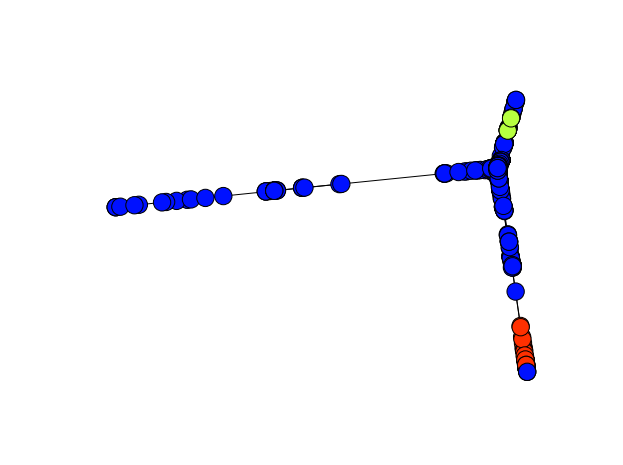

In [325]:
# pos = nx.spectral_layout(h_main, fixed=fixed_nodes, pos=inital_pos, iterations=5)
# nx.draw_networkx(h_main, pos=pos, node_color=labels)
nx.draw_spectral(h_main, node_color=labels, with_labels=False)
# f = plt.gcf()
plt.gcf().set_size_inches(8,6)
# ?plt.gcf() figure(figsize=(8,6))
# plt.show()

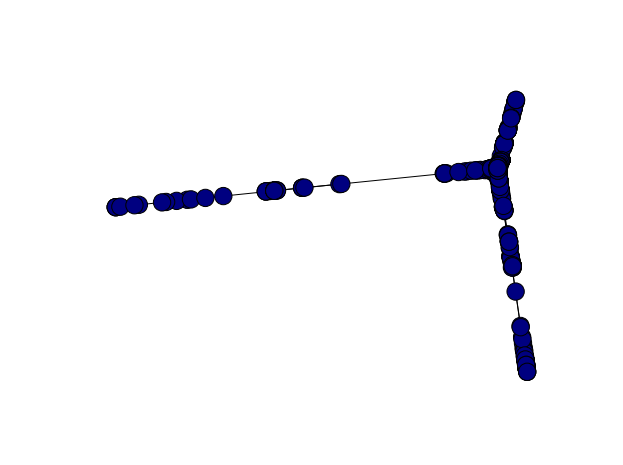

In [326]:
# pos = nx.spectral_layout(h_main, fixed=fixed_nodes, pos=inital_pos, iterations=5)
# nx.draw_networkx(h_main, pos=pos, node_color=labels)
nx.draw_spectral(h_main, node_color=labels2, with_labels=False)
# f = plt.gcf()
plt.gcf().set_size_inches(8,6)
# ?plt.gcf() figure(figsize=(8,6))
# plt.show()